import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
])

train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

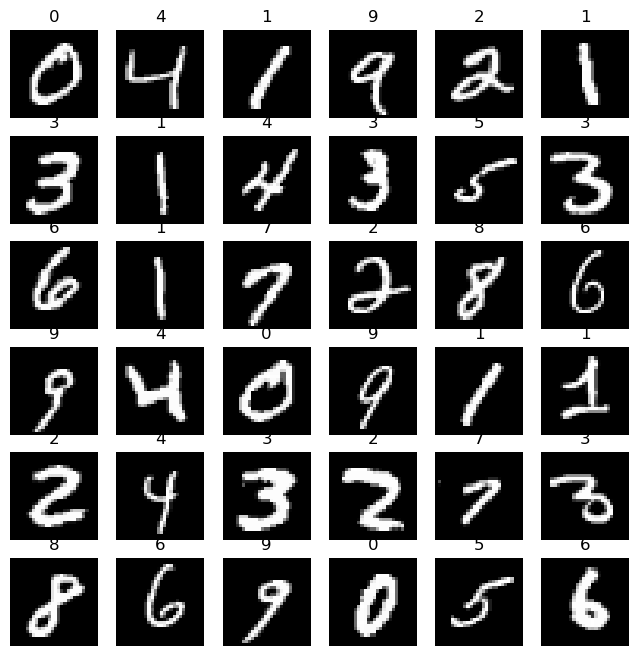

In [3]:
figure = plt.figure(figsize=(8,8))
cols, rows = 6, 6
for i in range(1, cols * rows + 1):
    img, label = train_data[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=5,stride=1)
        self.conv2 = nn.Conv2d(10,10,kernel_size=5,stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2) #2x2 maxpool
        self.fc1 = nn.Linear(4*4*10,100)
        self.fc2 = nn.Linear(100,10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) #24x24x10
        x = self.pool(x) #12x12x10
        x = F.relu(self.conv2(x)) #8x8x10
        x = self.pool(x) #4x4x10    
        x = x.view(-1, 4*4*10) #flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [5]:
def train_model(model):
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        imgs, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Loss: {running_loss/i:.3f}')
    running_loss = 0
            
def test_model(model):
    num_batches = len(test_loader)
    size = len(test_loader.dataset)
    test_loss, corrects = 0, 0

    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            test_loss += criterion(preds, yb).item()
            corrects += (preds.argmax(1) == yb).type(torch.float).sum().item()
    
        test_loss /= num_batches
        corrects /= size
        print(f"Test loss: \n Accuracy: {(100*corrects):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        
def vis_test(model):
    num_test = 10
    figure = plt.figure(figsize=(10, 2))
    
    model.eval()
    
    with torch.no_grad():
        total_images = len(test_data)
        random_indices = random.sample(range(total_images), num_test)
        
        for i, idx in enumerate(random_indices):
            img, label = test_data[idx]
            img = img.unsqueeze(0) 
            
            output = model(img)
            predicted_label = output.argmax(dim=1).item() 
            
            ax = figure.add_subplot(1, num_test, i + 1)
            ax.set_title(f'Label: {predicted_label}')
            ax.axis("off")
            ax.imshow(img.squeeze(), cmap="gray")
    
    plt.show()
        

In [6]:
print("Before Training")
vis_test(model)

epochs = 5

for i in range(epochs):
    print(f"Epoch: {i+1}")
    train_model(model)
    test_model(model)
    
print("After Training")
vis_test(model)

Epoch: 1
Loss: 0.267
Test loss: 
 Accuracy: 97.8%, Avg loss: 0.073855 

Epoch: 2
Loss: 0.068
Test loss: 
 Accuracy: 98.6%, Avg loss: 0.044871 

Epoch: 3
Loss: 0.048
Test loss: 
 Accuracy: 98.7%, Avg loss: 0.041289 

Epoch: 4
Loss: 0.038
Test loss: 
 Accuracy: 98.9%, Avg loss: 0.035780 

Epoch: 5
Loss: 0.031
Test loss: 
 Accuracy: 98.4%, Avg loss: 0.051100 

